## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [2]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [3]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [4]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

def y_fit_low(tau,T,V):
    return V*np.exp(-tau/T)

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [21]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'
#low :
file_E = root_path +'binned_Ecov_low_dl2.nc'
file_L = root_path +'binned_Lcov_low_dl2_flag10.nc'

dsE_low = xr.open_dataset(file_E).rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})
dsL_low = xr.open_dataset(file_L).rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})


ds_low_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl1.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl1.0.nc')])

ds_low_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])

### Visualization variance

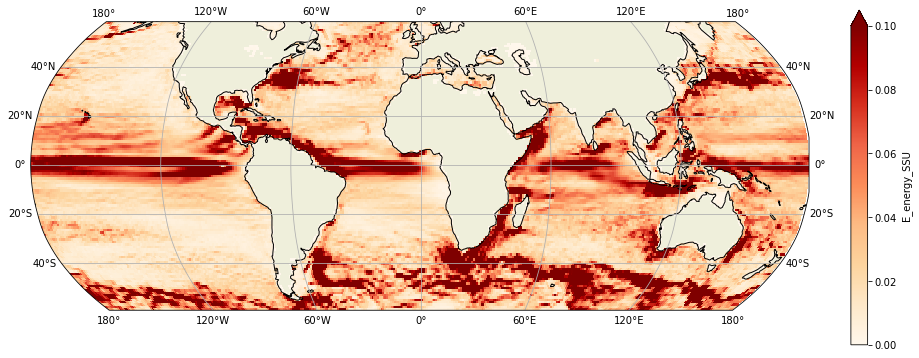

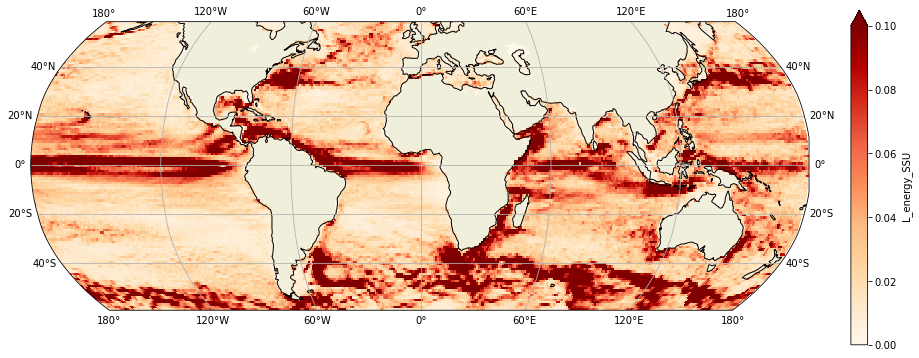

In [22]:
cmap = 'OrRd'
figsize=(15,15)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_dl1.E_energy_SSU,vlim=(0,0.1),colmap=cmap)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_dl1.L_energy_SSU,vlim=(0,0.1),colmap=cmap)

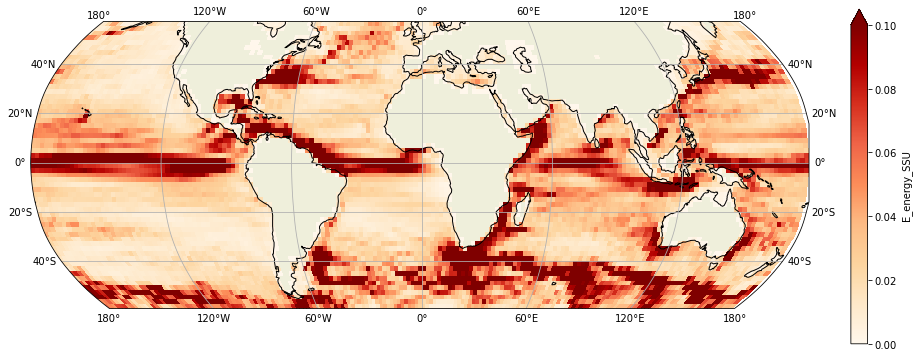

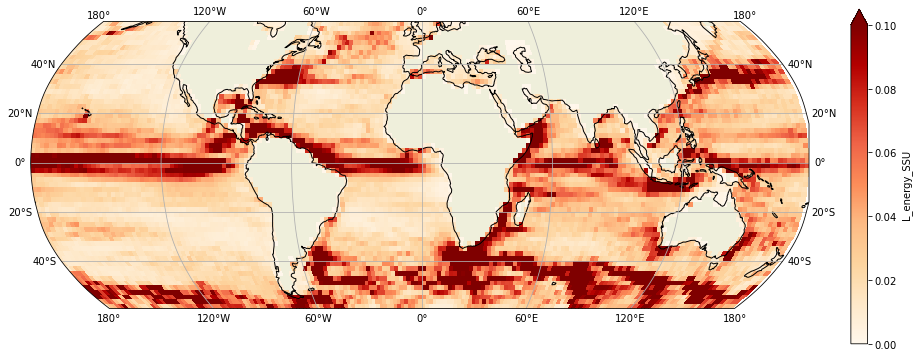

In [23]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_dl2.E_energy_SSU,vlim=(0,0.1),colmap=cmap)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_dl2.L_energy_SSU,vlim=(0,0.1),colmap=cmap)

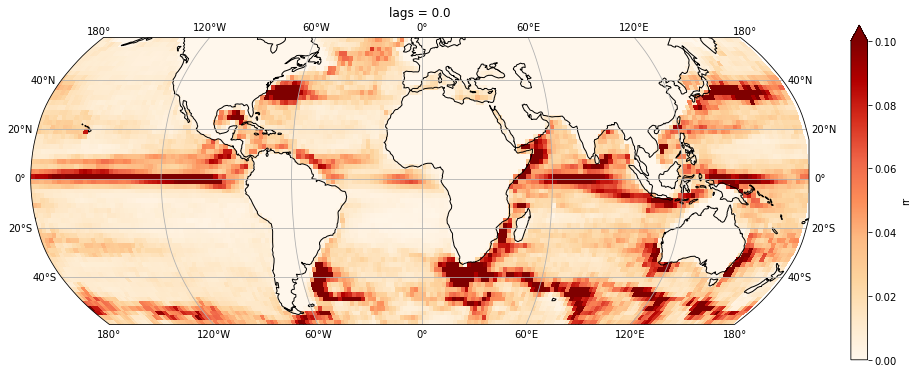

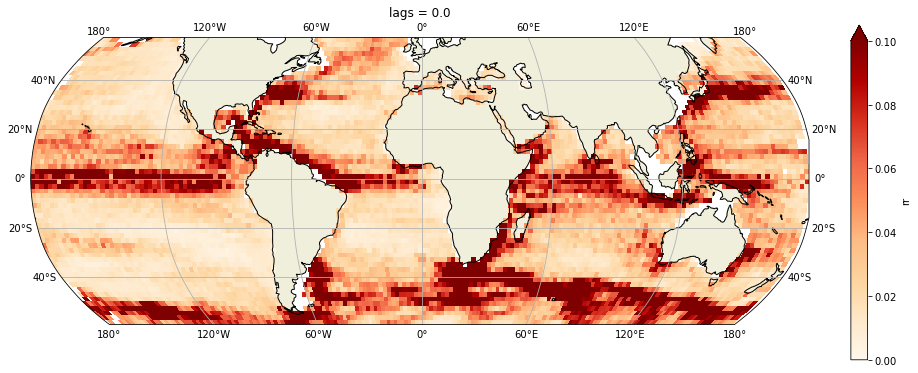

In [26]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_low.rr.isel(lags=0),vlim=(0,0.1),colmap=cmap)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low.rr.isel(lags=0),vlim=(0,0.1),colmap=cmap)

### Visualization autocovariance

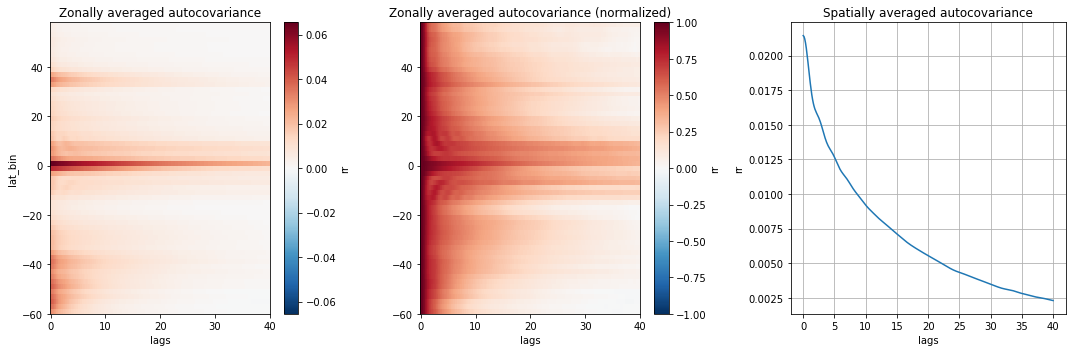

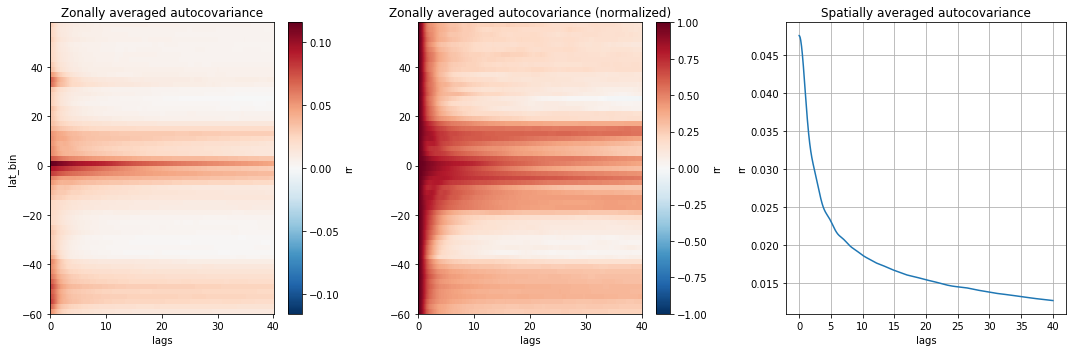

In [28]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
dsE_low.rr.mean('lon_bin').plot(ax=axs[0],y='lat_bin');axs[0].set_title('Zonally averaged autocovariance')
(dsE_low.rr.mean('lon_bin')/dsE_low.rr.mean('lon_bin').isel(lags=0)).plot(ax=axs[1],y='lat_bin');
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsE_low.rr.mean(['lon_bin','lat_bin']).plot(ax=axs[2]);
#dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL_low.rr.mean('lon_bin').plot(ax=axs[0]);axs[0].set_title('Zonally averaged autocovariance')
(dsL_low.rr.mean('lon_bin')/dsL_low.rr.mean('lon_bin').isel(lags=0)).plot(ax=axs[1]);
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL_low.rr.mean(['lon_bin','lat_bin']).plot(ax=axs[2]);
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

### Estimation of paraeters : fit 

In [30]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL_low.lags.max()+dt,dt) #time lag

In [31]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [32]:
dsE_low = dsE_low.where(dsE_low.rr.isel(lags=0)>0)

In [33]:
dsL_low = dsL_low.isel(lags=slice(0,None,3))

In [34]:
dsE_low_out = wrapper(dsE_low,'rr',y_fit_low,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))
dsL_low_out = wrapper(dsL_low,'rr',y_fit_low,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


/opt/anaconda3/envs/croco/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### Variance

Text(0.5, 1.0, 'Estimated Lagrangian variance (2°x2° bins)')

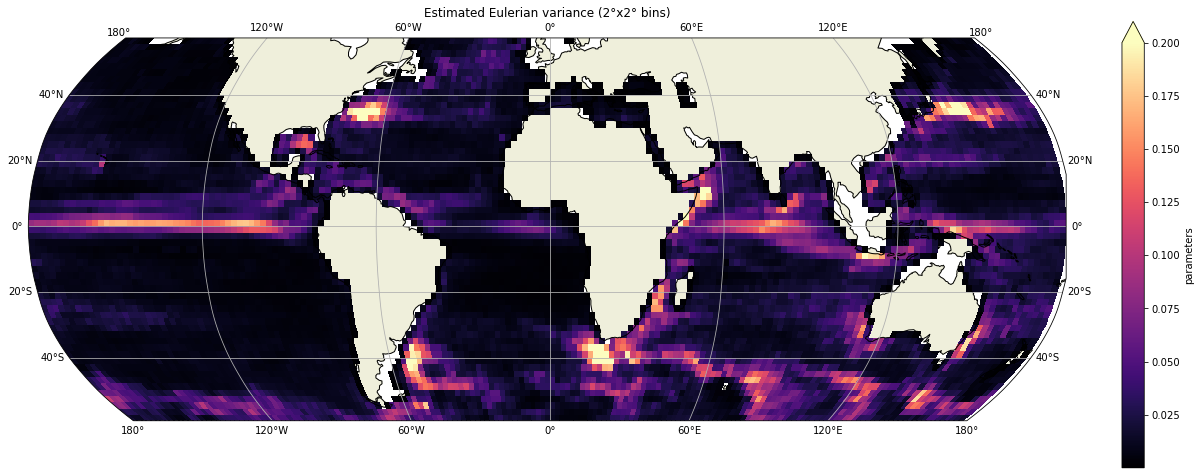

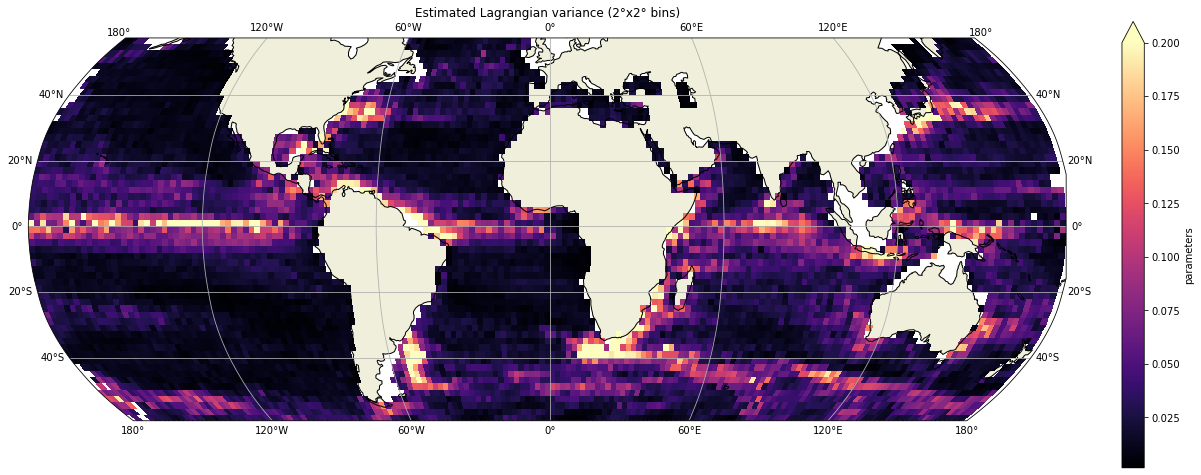

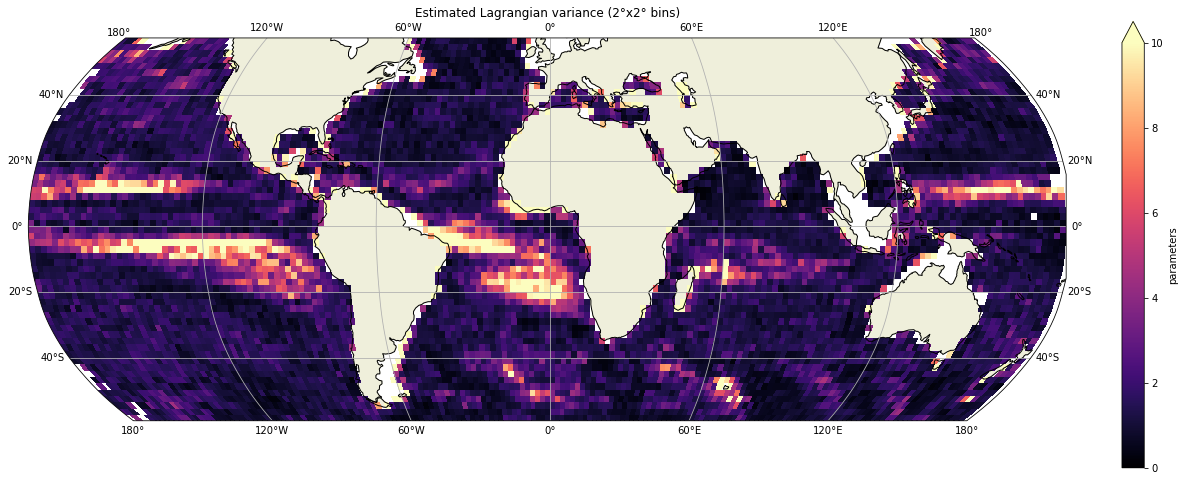

In [36]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_low_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.2))
ax.set_title('Estimated Eulerian variance (2°x2° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.2))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_out.sel(param = 'V').parameters/dsE_low_out.sel(param = 'V').parameters,
                   colmap='magma',vlim=(0,10))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')

#### Decorrelation timescale

Text(0.5, 1.0, 'Estimated Lagrangian decorrelation timescale (2°x2° bins)')

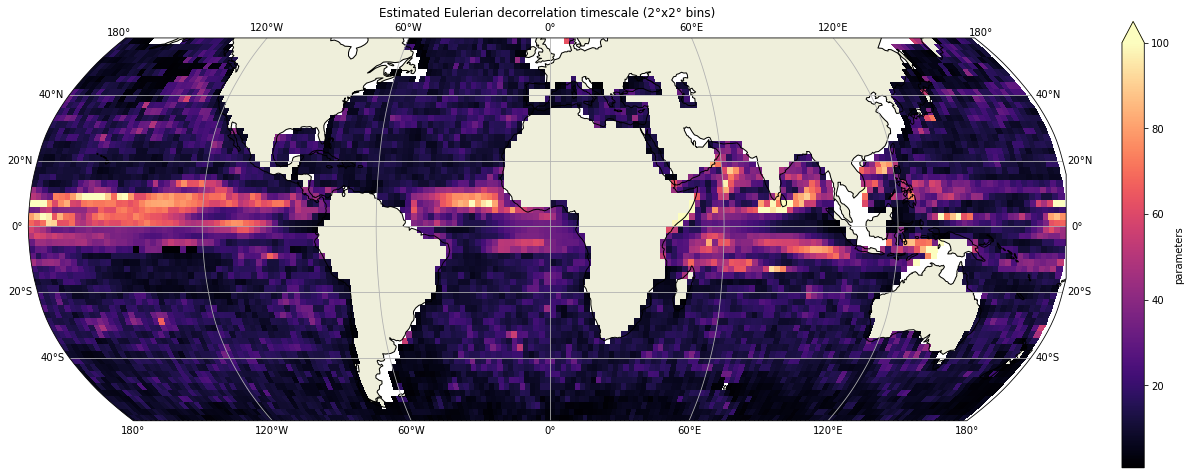

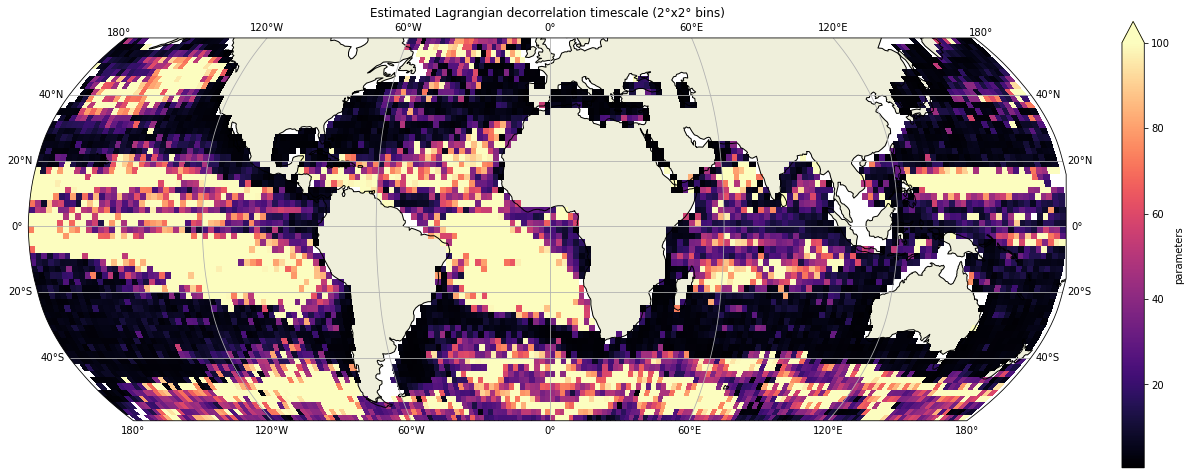

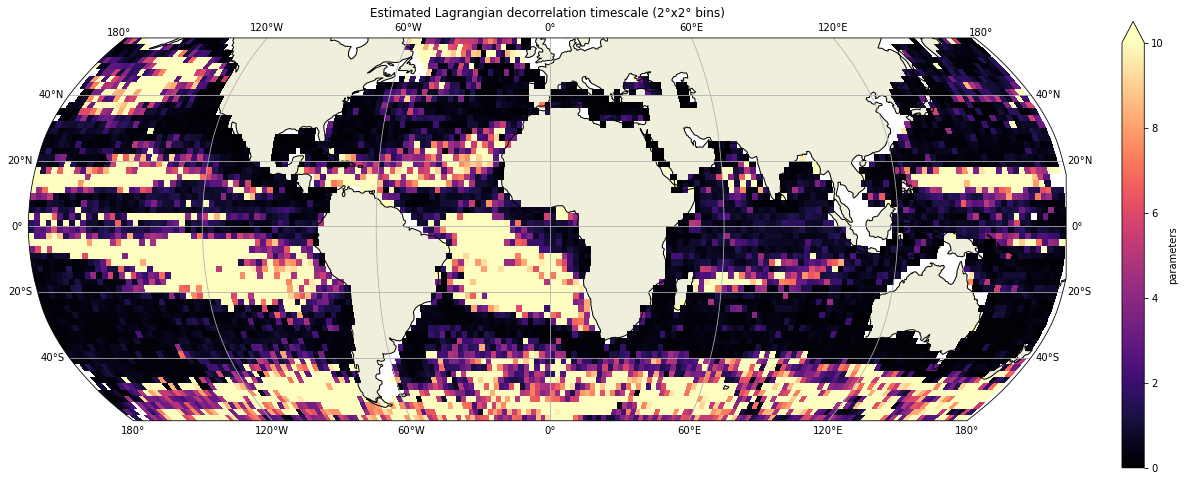

In [37]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_low_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian decorrelation timescale (2°x2° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian decorrelation timescale (2°x2° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_out.sel(param = 'T').parameters/dsE_low_out.sel(param = 'T').parameters,
                   colmap='magma',vlim=(0,10))
ax.set_title('Estimated Lagrangian decorrelation timescale (2°x2° bins)')

In [38]:
dsE_low['rr_norm'] = dsE_low.rr/dsE_low.rr.isel(lags=0)
dsL_low['rr_norm'] = dsL_low.rr/dsL_low.rr.isel(lags=0)

dsE_low_out['rr_norm'] = dsE_low_out.rr/dsE_low_out.rr.isel(lags=0)
dsL_low_out['rr_norm'] = dsL_low_out.rr/dsL_low_out.rr.isel(lags=0)

In [41]:
#2 points in different areas : short E and L timescales, large E and L timescales, L << E, L>E
areas = {'South atlantic ridge' : [[-15,-5],[-15,-15],[-15,-25]],
        'Gulf stream' : [[-70,35],[-60,35]],
        'South Indian ocean' : [[58,-44],[78,-44]],
        'Pacific (equator)' : [[-100,-5],[-100,5],[-100,10]]
        }

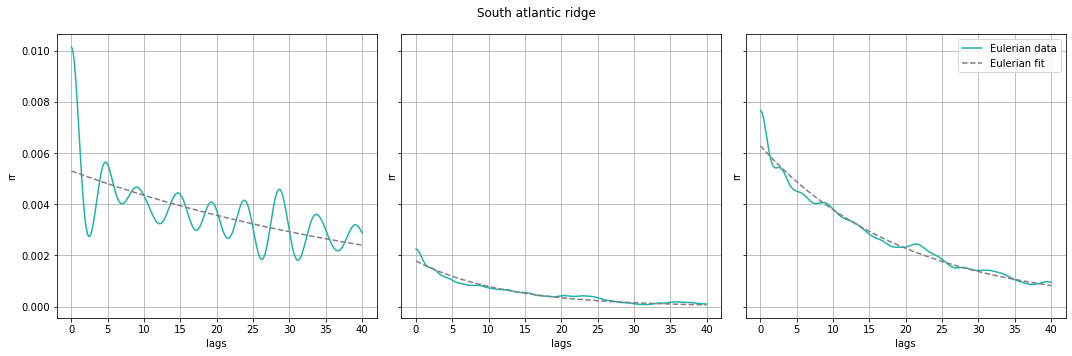

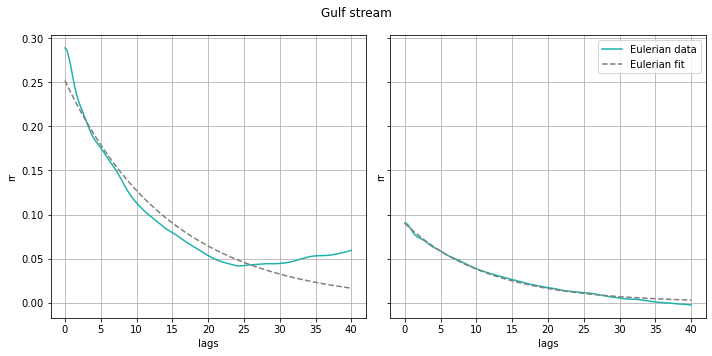

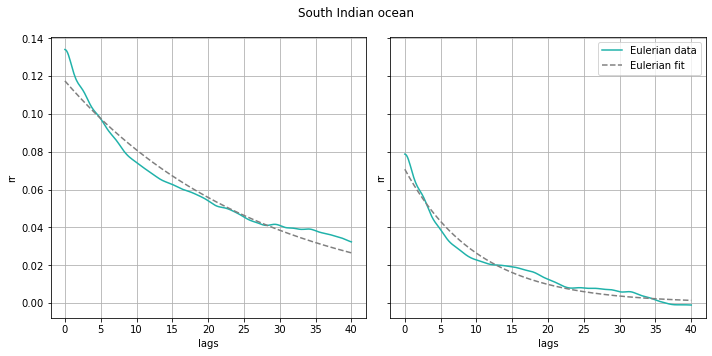

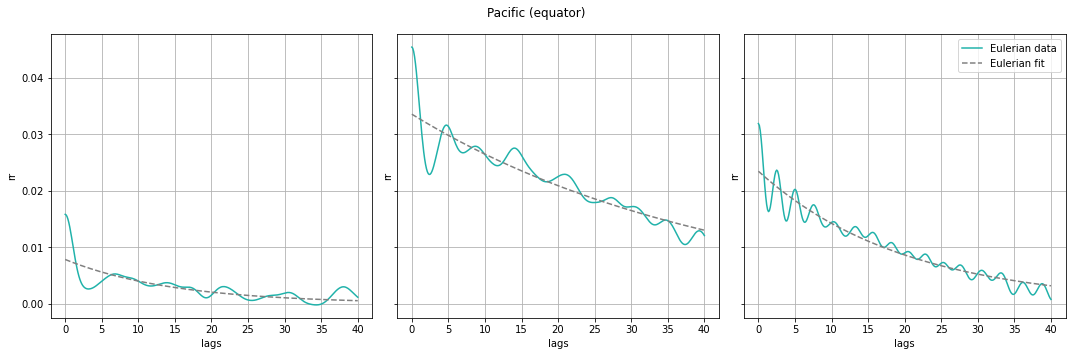

In [44]:

for k in areas.keys():
    fig,axs = plt.subplots(1,len(areas[k]),figsize=(5*len(areas[k]),5),sharey=True)
    for ax,pt in zip(axs,areas[k]):
        dsE_low.rr.sel(lat_bin=pt[1],lon_bin=pt[0],method='nearest').plot(ax=ax,c='lightseagreen',label='Eulerian data');
        dsE_low_out.rr.sel(lat_bin=pt[1],lon_bin=pt[0],method='nearest').plot(ax=ax,c='grey',linestyle='--',label='Eulerian fit');
#        dsL_low.rr.sel(lat_bin=pt[1],lon_bin=pt[0],method='nearest').plot(ax=ax,c='firebrick',label='Lagrangian data');
#        dsL_low_out.rr.sel(lat_bin=pt[1],lon_bin=pt[0],method='nearest').plot(ax=ax,c='k',linestyle='--',label='Lagrangian fit');
        ax.grid();ax.set_title('');
        low_var = dsE_low.rr.sel(lat_bin=pt[1],lon_bin=pt[0],method='nearest').isel(lags=0).values
#        ax.text(0,-0.004,r'$\overline{V}^2 \sim%s$'%np.around(low_var,decimals=4))
    ax.legend()
    fig.suptitle(k);fig.tight_layout();

In [62]:
Te_integrate = 2*(dsE_low.rr).integrate('lags')/dsE_low.rr.isel(lags=0)
Tl_integrate = 2*(dsL_low.rr).integrate('lags')/dsL_low.rr.isel(lags=0)
#.plot(y='lat_bin',vmax=10)

Text(0.5, 1.0, 'Estimated Eulerian decorrelation timescale (2°x2° bins)')

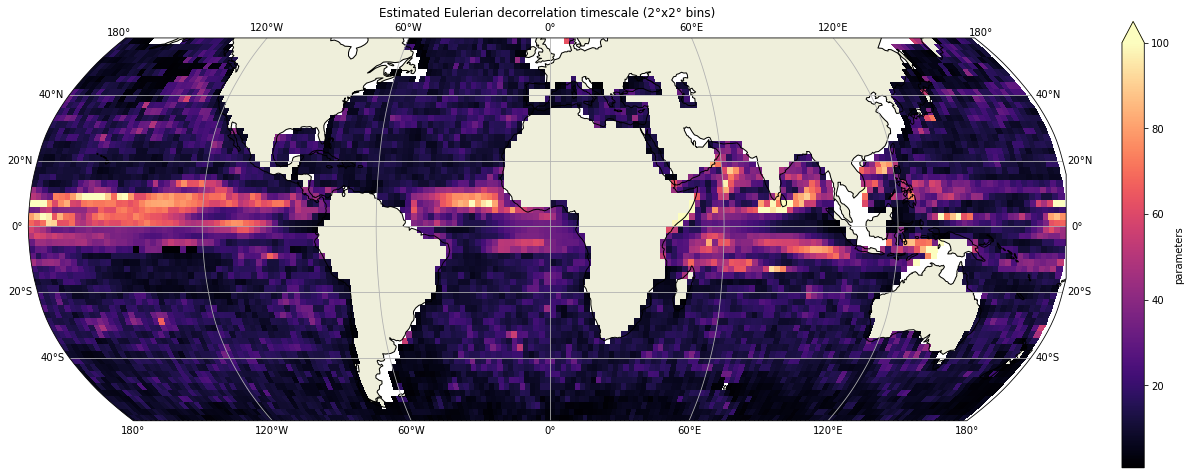

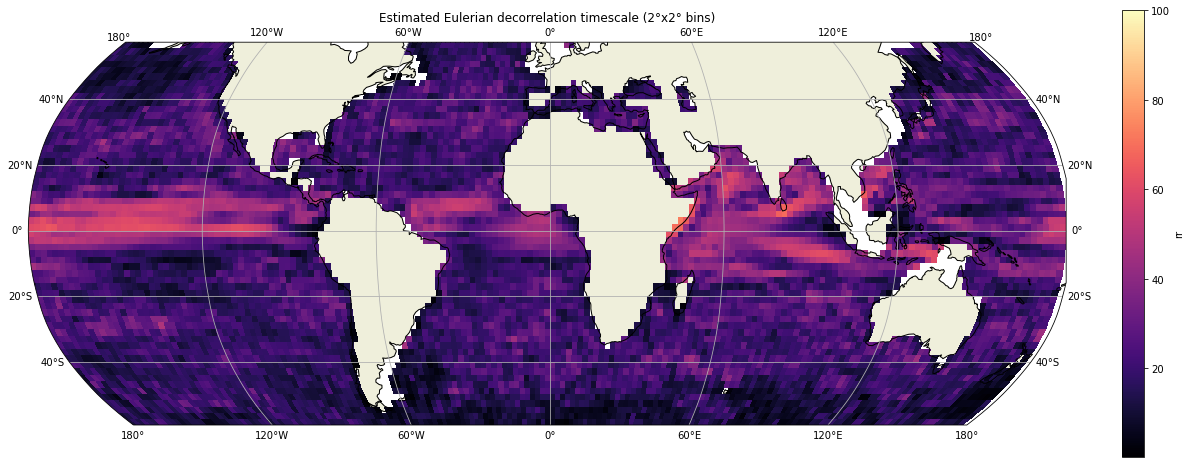

In [61]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_low_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian decorrelation timescale (2°x2° bins)')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(Te_integrate,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian decorrelation timescale (2°x2° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian decorrelation timescale (2°x2° bins)')

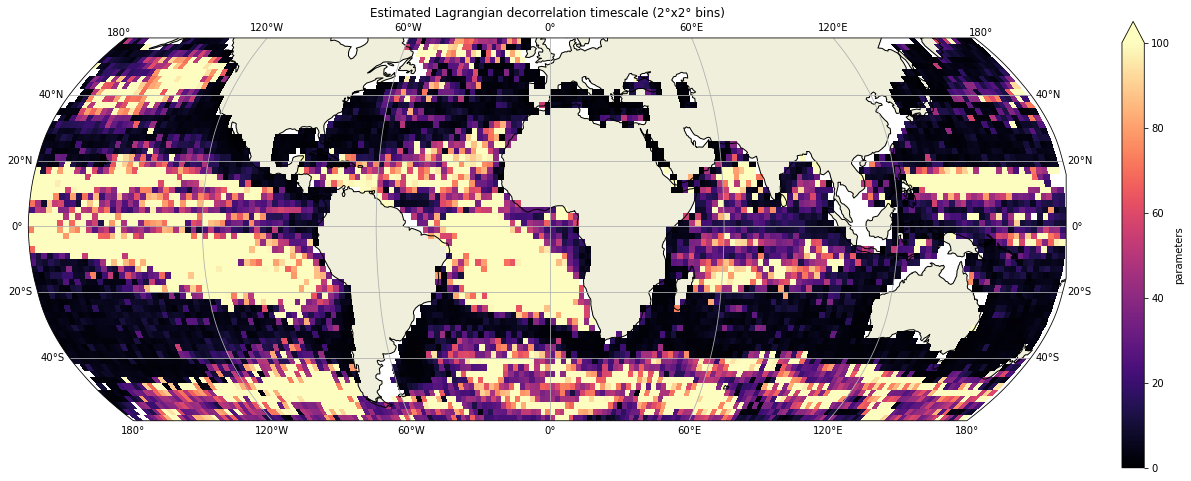

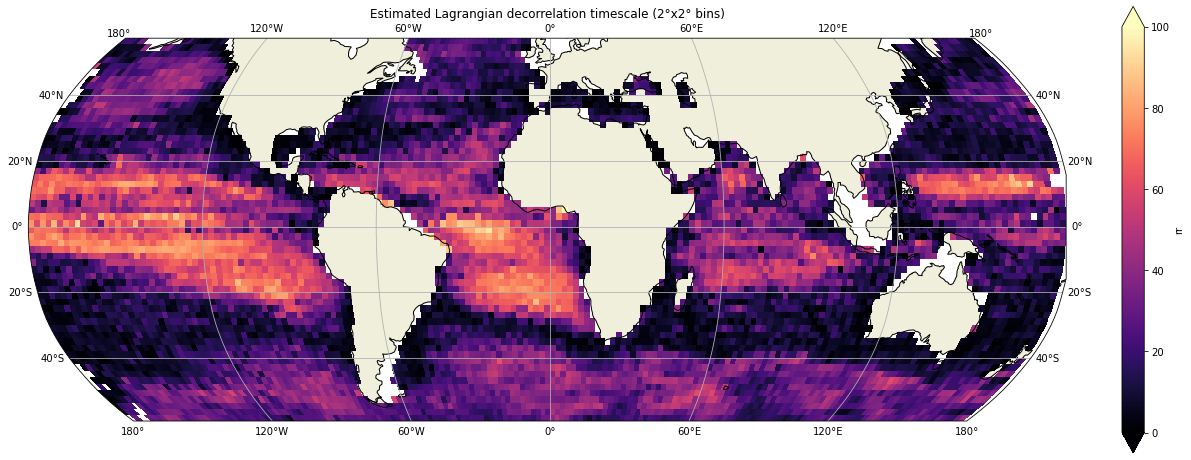

In [64]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_low_out.sel(param = 'T').parameters,colmap='magma',vlim=(0,100))
ax.set_title('Estimated Lagrangian decorrelation timescale (2°x2° bins)')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(Tl_integrate,colmap='magma',vlim=(0,100))
ax.set_title('Estimated Lagrangian decorrelation timescale (2°x2° bins)')